# Fake News Classification with Recurrent Convolutional Neural Networks

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=6, progress_bar=True, use_memory_fs=False,)
import spacy
import en_core_web_md
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


# Panderlla Configuration customisation
C:\Users\johnd\Project\Program\Dataset\Fake.csv

In [4]:
import psutil

psutil.cpu_count(logical=False)

8

## Read Data

In [5]:
data = pd.read_csv('../Dataset/Combined_news_dataset/combined_news_data_processed.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74011 entries, 0 to 74010
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   74011 non-null  object
 1   text    74011 non-null  object
 2   label   74011 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

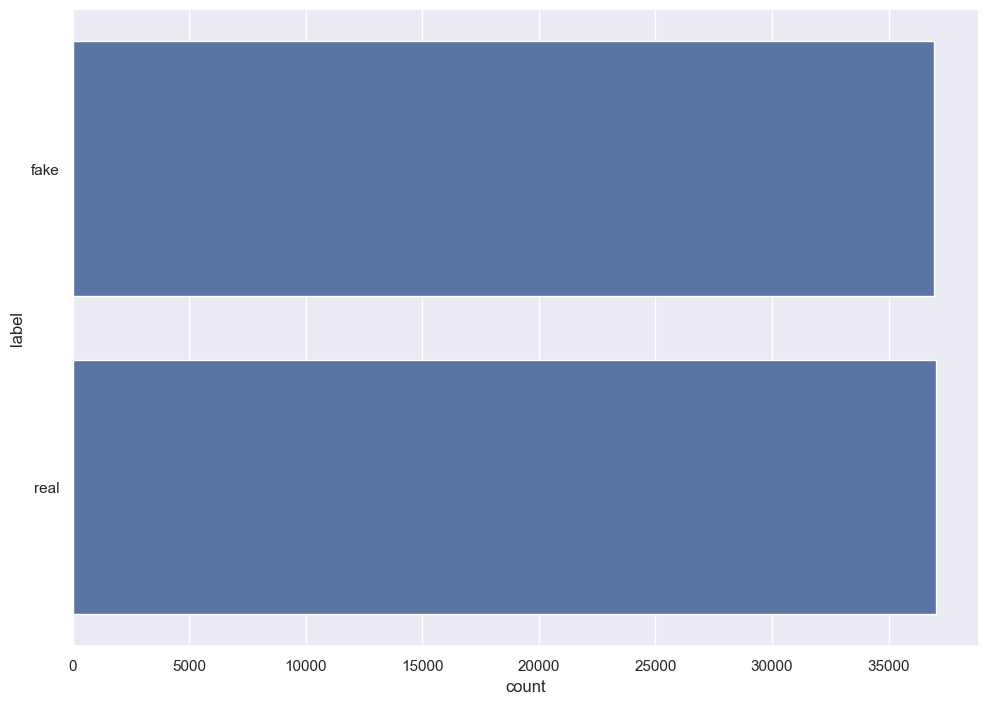

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
conversion_dict = {0: 'real', 1: 'fake'}
sns.countplot(data['label'].apply(lambda x: conversion_dict[x]))

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
data['length'] = data['text'].apply(lambda x: len(x.split(' ')))

C:\Users\johnd\AppData\Local\Temp\ipykernel_4280\1475792507.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['length'])


<Axes: xlabel='length', ylabel='Density'>

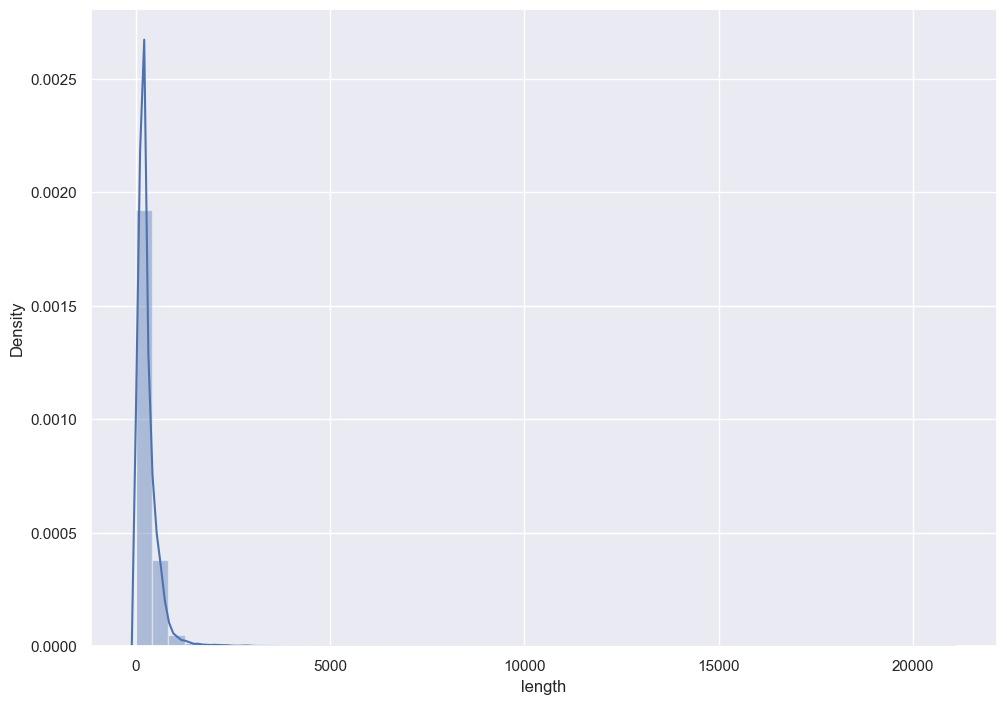

In [8]:
sns.distplot(data['length'])

In [9]:
data['length'].describe()

count    74011.000000
mean       287.917215
std        324.786965
min          1.000000
25%        126.000000
50%        215.000000
75%        357.000000
max      21011.000000
Name: length, dtype: float64

## Preprocessing the Text Data

In [10]:
from preprocessor import preprocessor

# Now you can use preprocessor function without facing the NameError issue
X = data['text'].parallel_apply(preprocessor)
y = data['label']


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

data_processed = pd.DataFrame({'title': data['title'], 'text': X, 'label': y})
data_processed.to_csv('./combined_news_data_processed.csv', index=False)

## Topic Modeling with Latent Dirichlet Allocation

In [15]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import pyLDAvis

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

def display_topics_pipeline(pipeline_lda, no_top_words):
    vectorizer = pipeline_lda.steps[0][1]
    lda = pipeline_lda.steps[1][1]
    tensorflow_feature_names = vectorizer.get_feature_names()
    display_topics(lda, tensorflow_feature_names, no_top_words)

### Real News

In [17]:
import pyLDAvis
import sklearn

print(pyLDAvis.__version__)
print(sklearn.__version__)

3.4.0
1.3.2


In [13]:
real_news = data_processed[data_processed['label'] == 1]

num_topics = 10
num_features=5000

vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
lda = LatentDirichletAllocation(n_components=num_topics,
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0)

lda_pipeline = Pipeline([('vectorizer', vectorizer), ('lda', lda)])
lda_pipeline.fit(real_news['text'])

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.95, max_features=5000, min_df=2,
                                 stop_words='english')),
                ('lda',
                 LatentDirichletAllocation(learning_method='online',
                                           learning_offset=50.0, max_iter=5,
                                           random_state=0))])

In [18]:

pyLDAvis.enable_notebook()
data_vectorized = vectorizer.fit_transform(data_processed['text'])
dash = pyLDAvis.sklearn.prepare(lda_pipeline.steps[1][1], data_vectorized, vectorizer, mds='tsne')

AttributeError: module 'pyLDAvis' has no attribute 'sklearn'

In [ ]:
pyLDAvis.save_html(dash, 'real_news_lda.html')

### Fake News

In [ ]:
fake_news = data_processed[data_processed['label'] == 0]

num_topics = 10
num_features=5000

vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
lda = LatentDirichletAllocation(n_components=num_topics,
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0)

lda_pipeline = Pipeline([('vectorizer', vectorizer), ('lda', lda)])
lda_pipeline.fit(fake_news['text'])

pyLDAvis.enable_notebook()
data_vectorized = vectorizer.fit_transform(data_processed['text'])
dash = pyLDAvis.sklearn.prepare(lda_pipeline.steps[1][1], data_vectorized, vectorizer, mds='tsne')

NameError: name 'pyLDAvis' is not defined

In [ ]:
pyLDAvis.save_html(dash, 'fake_news_lda.html')

In [ ]:
import tensorflow as tf
tf.__version__

'2.16.1'

## Defining and Training the Model

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import hashing_trick
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class LSTM_Text_Classifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, embedding_vector_length, max_seq_length, lstm_layers, batch_size=32, num_epochs=3, use_hash=False,
                dropout=None, conv_params=None):
        
        self.embedding_vector_length = embedding_vector_length
        self.max_seq_length = max_seq_length
        self.lstm_layer_sizes = lstm_layers
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.use_hashing_trick = use_hash
        if not self.use_hashing_trick:
            self.tokenizer = Tokenizer()
        self.dropout = dropout
        self.conv_params = conv_params
        
    
    def _get_word_index(self, word):
        
        try:
            return self.tokenizer.word_index[word]
        except:
            return None
        
    def _text_to_int_sequence(self, text):
        seq = [self._get_word_index(word) for word in text_to_word_sequence(text)]
        return [index for index in seq if index]
        
    def fit(self, X, y, validation_data):
        
        with tf.device('/gpu:0'):
            all_X = pd.concat([X, validation_data[0]])
        if self.use_hashing_trick:
            all_words = set()
            for text in all_X:
                new_words = set(text_to_word_sequence(text))
                all_words = all_words.union(new_words)
            self.max_vocab = len(all_words)*1.3
            
            max_vocab = self.max_vocab
            for i in range(len(X)):
                X[i] = hashing_trick(X[i], max_vocab, hash_function='md5')
            X_pad = sequence.pad_sequences(X, maxlen=self.max_seq_length)
            
            X_valid = validation_data[0]
            
            for i in range(len(X_valid)):
                X_valid[i] = hashing_trick(X_valid[i], max_vocab, hash_function='md5')
            X_valid_pad = sequence.pad_sequences(X_valid, maxlen=self.max_seq_length)
        
            y_valid = validation_data[1]
            
        else:    
            print('Fitting Tokenizer...')
            self.tokenizer.fit_on_texts(all_X)
            self.max_vocab = len(self.tokenizer.word_index) + 20
            X = X.apply(self._text_to_int_sequence)
            X_pad = sequence.pad_sequences(X, maxlen=self.max_seq_length)
        
            X_valid = validation_data[0].apply(self._text_to_int_sequence)
            X_valid_pad = sequence.pad_sequences(X_valid, maxlen=self.max_seq_length)
        
            y_valid = validation_data[1]
        
        self.model = Sequential()
        self.model.add(Embedding(self.max_vocab, self.embedding_vector_length, input_length=self.max_seq_length))
            
        if self.conv_params is not None:
            use_pooling = False
            if self.conv_params['pool_size'] is not None:
                use_pooling = True
            
            for i in range(self.conv_params['n_layers']):
                self.model.add(Conv1D(filters=2*(i+1)*self.conv_params['filters'], 
                                      kernel_size=self.conv_params['kernel_size'], 
                                      padding='same', activation='relu'))
                if use_pooling:
                    self.model.add(MaxPooling1D(pool_size=self.conv_params['pool_size']))

            
        if len(self.lstm_layer_sizes) > 1:
            for lstm_layer_size in self.lstm_layer_sizes[:-1]:
                self.model.add(LSTM(lstm_layer_size, return_sequences=True))
                self.model.add(Dropout(self.dropout))
            self.model.add(LSTM(self.lstm_layer_sizes[-1]))
        else:
            self.model.add(LSTM(self.lstm_layer_sizes[0]))
        if self.dropout is not None:
            self.model.add(Dropout(self.dropout))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=1,
                              verbose=2, mode='max')
        
        checkpoint = ModelCheckpoint(filepath='best_model',
                                     monitor='val_accuracy',
                                     mode='max',
                                     save_best_only=True)
        
        callbacks_list = [early_stopping, checkpoint]
        print(self.model.summary())
        
        print('Fitting model...')
        self.model.fit(X_pad, y, validation_data=(X_valid_pad, y_valid), 
                  epochs=self.num_epochs, batch_size=self.batch_size, callbacks=callbacks_list)
        
        
    def predict(self, X):
        
        if type(X) == pd.core.frame.DataFrame or type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        else:
            X = map(X, self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        
    def predict_classes(self, X):
        
        if type(X) == pd.core.frame.DataFrame or type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(np.array(X))
        else:
            X = map(X, self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(np.array(X))
    
    def predict_proba(self, X):
        
        if type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = sequence.pad_sequence(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(np.array(X))
        else:
            X = map(X, self._text_to_word_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(np.array(X))
    
    def load_model(self, file_path):
        
        self.model = load_model(file_path)
    
    def score(self, X, y):
        
        pred = self.predict(X)
        return accuracy_score(y, pred)
    

### Model Training

In [ ]:
import keras
import tensorflow as tf

print(keras.__version__)
print(tf.__version__)

3.1.1
2.16.1


In [ ]:
lstm_classifier = LSTM_Text_Classifier(embedding_vector_length=64, max_seq_length=512, dropout=0.1, 
                                            lstm_layers=[128, 128], batch_size=256, num_epochs=5, use_hash=False,
                                           conv_params={'filters': 128, 
                                                        'kernel_size': 5, 
                                                        'pool_size': 2,
                                                        'n_layers': 3})

In [ ]:
lstm_classifier.fit(X_train, y_train, validation_data=(X_valid, y_valid))

Fitting Tokenizer...


ValueError: Unrecognized keyword arguments passed to Embedding: {'input_length': 512}

## Validation Results

In [ ]:
lstm_classifier.load_model('best_model')

In [ ]:
from keras.utils import plot_model
plot_model(
    lstm_classifier.model,
    to_file="recurrent_conv_net.png",
    show_shapes=True,
    show_layer_names=True)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = lstm_classifier.predict_classes(X_valid)
print(confusion_matrix(y_valid, y_pred))
print(classification_report(y_valid, y_pred, digits=4))

## Testing Results

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_test = lstm_classifier.predict_classes(X_test)
print(classification_report(y_test, y_pred_test))